# Time Series Analysis : An explorative study

### Problem Statement: Failure Prediction 

Objective: Predict the number of failures that will occur at any point of time in the day by utilizing a JSON file containing timestamps of failures. Implement a forecasting method over a time granularity. 



The number of failures have been supplied as a Json File in the excercise. The Json file was converted to a pandas data frame and the following analysis were performed on the file 

1. The files were aggregated to find the number of failures in each 15 minute intervel

2. An exploratory data analysis was performed, to identify the trends and seasonalilty factors in the data

3. In an effort to forecast the the values from the data, 3 models were deployed: ARIMA, SARIMAX, LSTM

Based on the performance of the models, LSTM is the most effective model for forecasting.

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pmdarima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pylab import rcParams
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error

## Loading the JSON data into a dataframe

In [2]:
# Load the data from the JSON file
with open('failuretime.json') as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data)
df.head()

,time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df1 = pd.to_datetime(df['time'])
df1.head()

0   1970-01-01 20:13:18
1   1970-01-01 20:16:10
2   1970-01-01 20:16:37
3   1970-01-01 20:16:36
4   1970-01-01 20:26:21
Name: time, dtype: datetime64[ns]

In [5]:
df2 = pd.DataFrame(df1)
df2 = df2.reset_index()
df2 = df2.set_index('time')
df2.head()

,index
time,
1970-01-01 20:13:18,0
1970-01-01 20:16:10,1
1970-01-01 20:16:37,2
1970-01-01 20:16:36,3
1970-01-01 20:26:21,4


## Resampling data on 15 min frequency and counting the number of failures

In [6]:
count = df2.resample('15min').count()
count = count.rename(columns={"index": "Count"})
count.head()

,Count
time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
count.tail()

,Count
time,
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


## Preparing data for visualization

In [8]:
c1 = count.reset_index()
c1 = c1.rename(columns={"time": "Time"})
c1.head()

,Time,Count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [9]:
c2 = c1.copy()
c2['Year'] = [i.year for i in c1['Time']]
c2['Month'] = [str(i.month) for i in c1['Time']]
c2['Day'] = [i.day for i in c1['Time']]
c2['Hour'] = [i.hour for i in c1['Time']]
c2['Minute'] = [i.minute for i in c1['Time']]
c2

,Time,Count,Year,Month,Day,Hour,Minute
0,1970-01-01 20:00:00,2,1970,1,1,20,0
1,1970-01-01 20:15:00,6,1970,1,1,20,15
2,1970-01-01 20:30:00,9,1970,1,1,20,30
3,1970-01-01 20:45:00,7,1970,1,1,20,45
4,1970-01-01 21:00:00,1,1970,1,1,21,0
...,...,...,...,...,...,...,...
9783,1970-04-13 17:45:00,5,1970,4,13,17,45
9784,1970-04-13 18:00:00,5,1970,4,13,18,0
9785,1970-04-13 18:15:00,2,1970,4,13,18,15
9786,1970-04-13 18:30:00,7,1970,4,13,18,30


# Visualization of the time series data for 15 min aggregate counts

In [10]:
#The plot below is interactive
fig = px.line(c1, x='Time', y="Count",title="Count of failures every 15 min")
fig.show()

The above plot shows us the trend of failures over a 4 month period. The data is aggregated on a 15 min window. I choose plotly to visualize this data as one can zoom in and observe the plot. Through the plot, we can see that there is a bit of cyclicity in the number of failures, but we cannot really say if it is seasonal. The number of failures seem to be increasing after the 2nd month, with the biggest peak on March 1st.

In [10]:
#The plot below is interactive
fig = px.line(x = c2['Time'],y = c2['Count'], facet_col=c2['Month'], facet_col_wrap=2, title = 'Monthwise failure counts',
             labels={"y": "Count","x": "Date"})
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(matches=None)
fig.show()

<AxesSubplot: xlabel='Month', ylabel='Count'>

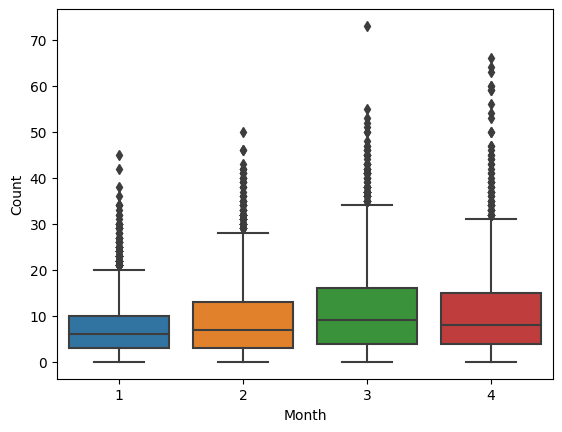

In [11]:
sns.boxplot(x="Month", y="Count", data=c2)

Text(0.5, 1.0, 'Total Failures By Month')

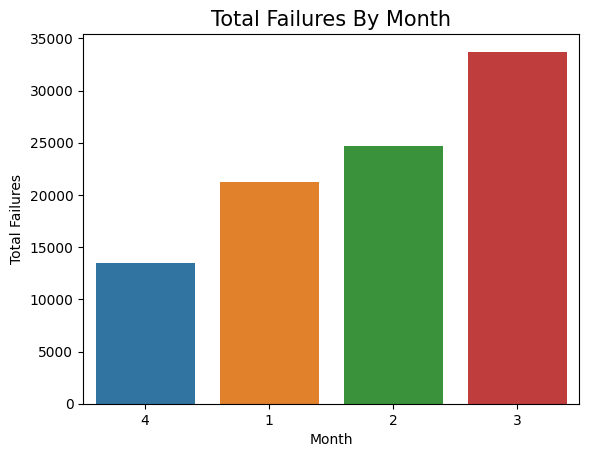

In [12]:
fig, ax1 = plt.subplots()
monthAggregated = pd.DataFrame(c2.groupby("Month")["Count"].sum()).reset_index().sort_values('Count')
sns.barplot(data=monthAggregated,x="Month",y="Count")
ax1.set(xlabel='Month', ylabel='Total Failures')
ax1.set_title("Total Failures By Month",fontsize=15)

The above plot shows the total number of failures by the month. The 3rd month has the highest failures among all. The 4th month does not have data for the whole month, hence it's number of failures is also the smallest. However, for 13 days of 4th month, the failures are closer to the 1st month. Hence we can assume that the rate of failure increased as the months went by.

Text(0.5, 1.0, 'Total Failures on a hourly basis')

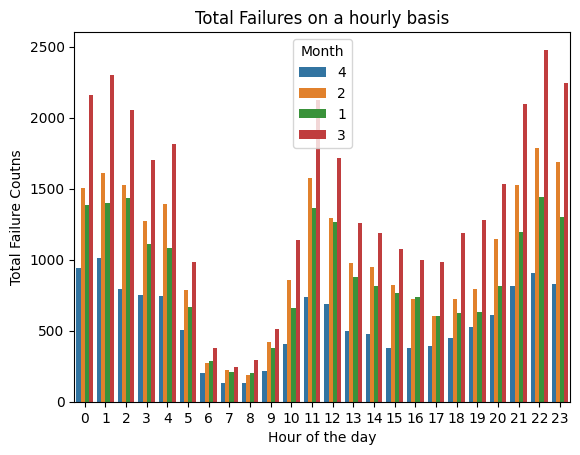

In [13]:
fig, ax2 = plt.subplots()
A1 = pd.DataFrame(c2.groupby(["Hour",'Month'])["Count"].sum()).reset_index().sort_values('Count')
sns.barplot(data=A1,x="Hour",y="Count",hue = 'Month',ax=ax2)
ax2.set(xlabel='Hour of the day', ylabel='Total Failure Coutns')
ax2.set_title("Total Failures on a hourly basis")

The above plot shows how the failures count varies according to the hour of the day across months. The start and end of the day seem to have a lot more failures in general. The failures increases again in the middle of the day. 

Text(0.5, 1.0, 'Total Failures day of the day across months')

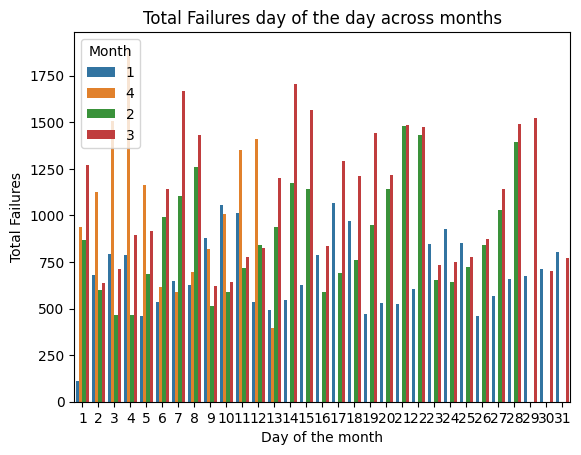

In [14]:
fig, ax3 = plt.subplots()
A2 = pd.DataFrame(c2.groupby(["Day",'Month'])["Count"].sum()).reset_index().sort_values('Count')
sns.barplot(data=A2,x="Day",y="Count",hue = 'Month',ax=ax3)
ax3.set(xlabel='Day of the month', ylabel='Total Failures')
ax3.set_title("Total Failures day of the day across months")

The above plot demonstrates the number of failures across the days. 

In [15]:
px.bar(x = A2["Day"],y = A2["Count"],color = A2['Month'],text_auto=True,title = 'Daily failure counts',
             labels={"y": "Count","x": "Day","color":"Month"})

# Analysis
## Understanding the seasonality and trends of the data

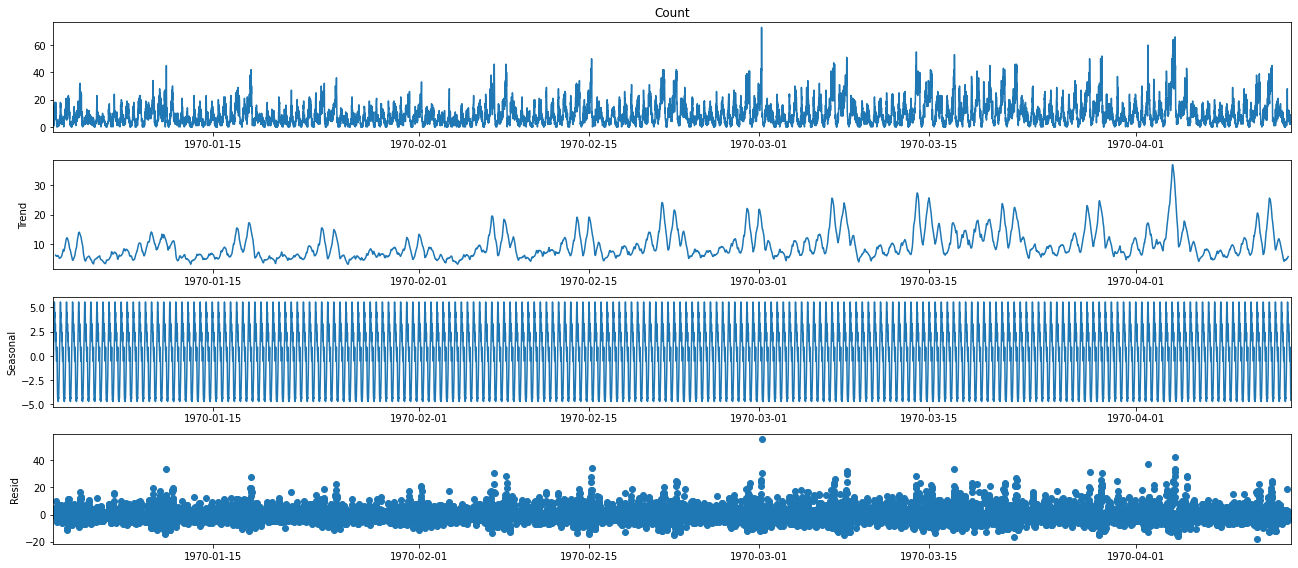

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(count['Count'], model='additive', period = 48)
fig = decomposition.plot()
plt.show()

In [12]:
count.describe()

,Count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


## Splitting the data into test and train

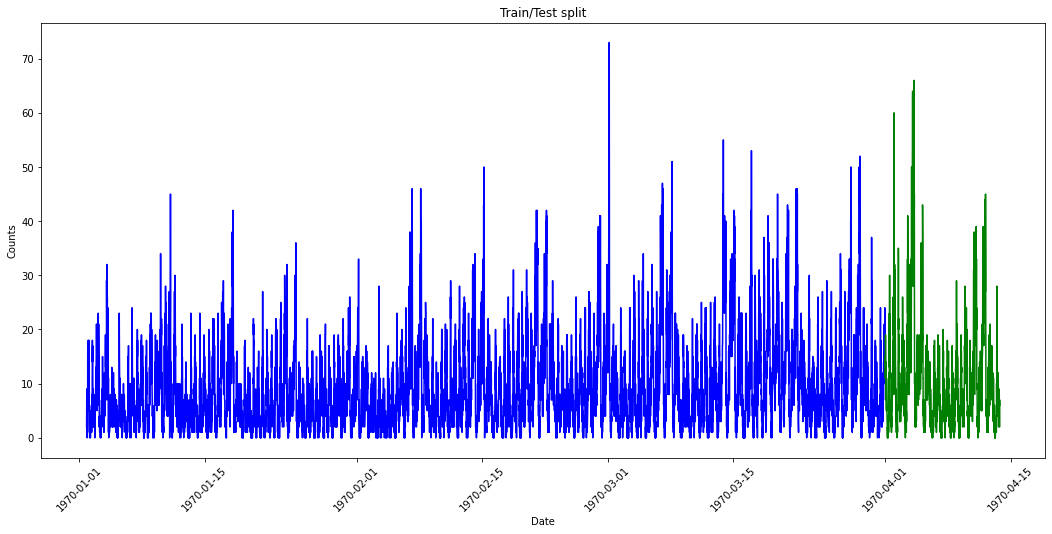

In [13]:
train = count[count.index.month <= 3] # WE cannot randomly split timeseries data, hence we use April as the test data and the rest as train data
test = count[count.index.month > 3 ]
plt.plot(train['Count'], color = "Blue")
plt.plot(test['Count'], color = "Green")
plt.ylabel('Counts')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split")
plt.show()

In [14]:
print("len(test)=",len(test),";","len(train)=",len(train))

len(test)= 1228 ; len(train)= 8560


## Timeseries forecasting

In time series forecasting, models are trained to identify patterns in datasets. With this methods,we can find the future values that the time series will take. This means that we should be able to predict the number of failures happening in the future. 

We will be applying ARIMA and SARIMA for our dataset. Before that, we need to find whethe the dataset is stationery and then find the p,q, and d based on that. 

Augmented Dickey-Fuller (ADF) is a test to check for stationarity of the dataset. At the core of ADF is a hypothesis test that tests whether the dataset is stationery or not. Simiarly, ACF and PACF plots will be used to determine the p and q for Arima and Sarima.

# Differentiating

In [15]:
c3 = count.copy()
c3['d'] = c3['Count']-c3['Count'].shift(1)

In [16]:
c3 = c3.dropna()

In [17]:
adfuller(c3['d'])

(-28.87291508084577,
 0.0,
 38,
 9748,
 {'1%': -3.431021011779871,
  '5%': -2.8618365464471562,
  '10%': -2.5669278465492074},
 56467.574602675064)

adfuller test gives a p-value of 0, which is lower than the alpha value of 0.01. Hence we can assume that the data is stationary.Here, d=1 as we applied differentiation. The below plots will help us get the value of p and q. 

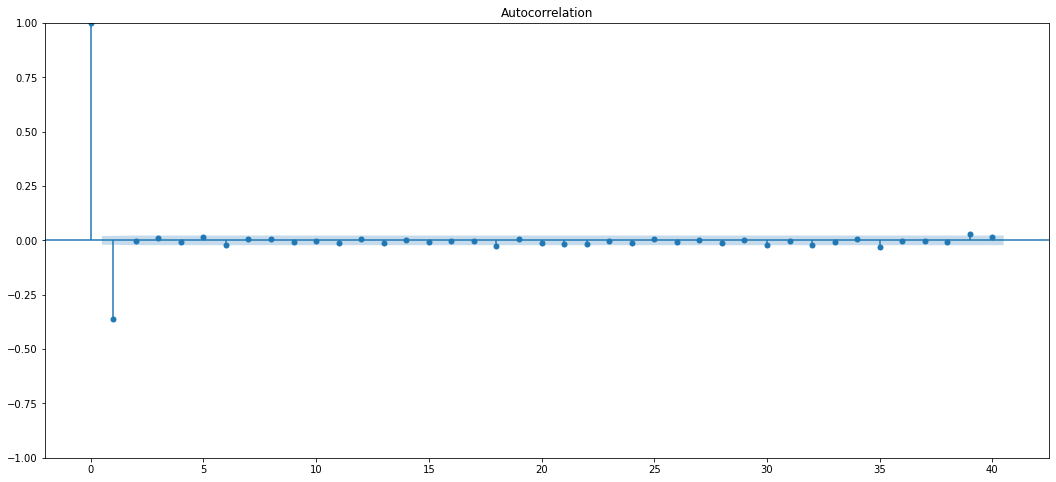

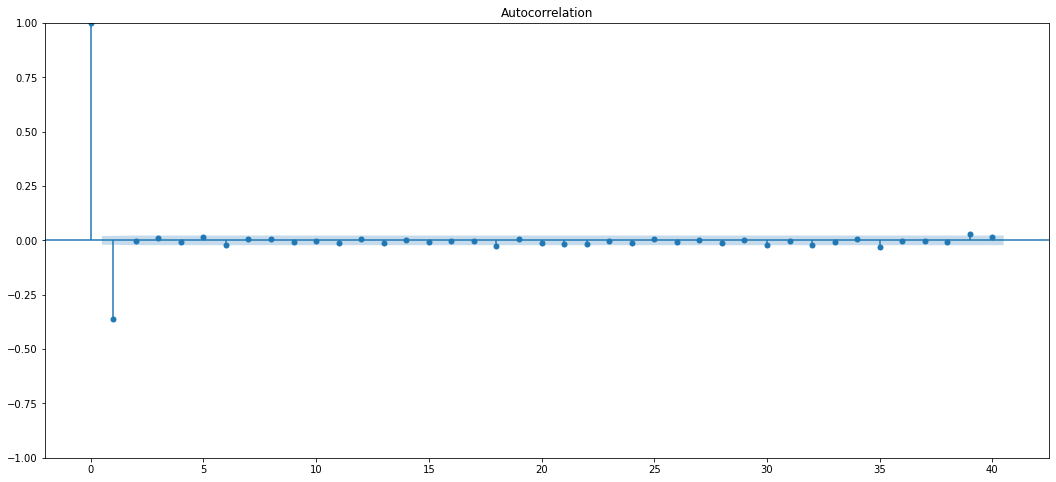

In [19]:
sm.graphics.tsa.plot_acf(c3['d'],lags=40)

c:\Users\Smous\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



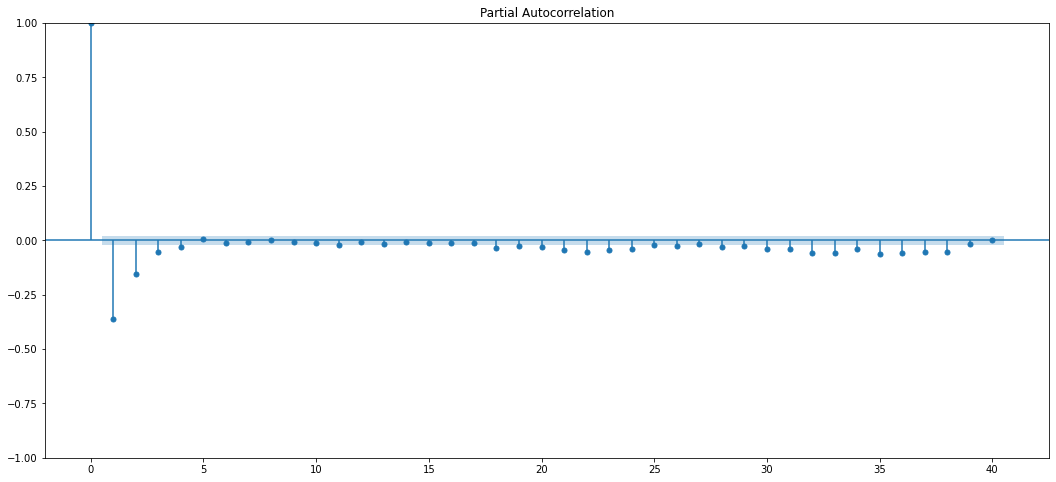

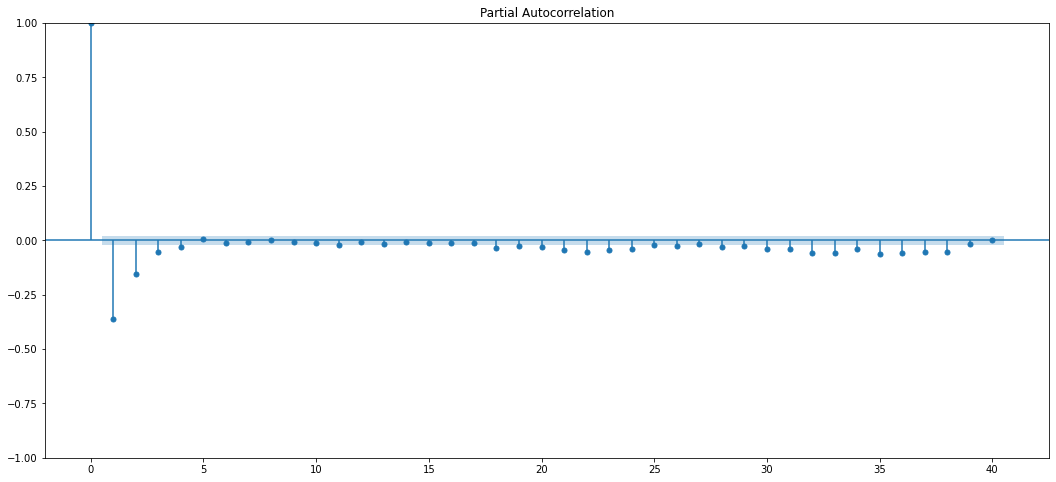

In [18]:
sm.graphics.tsa.plot_pacf(c3['d'],lags=40)

# Arima

In [20]:
amodel=ARIMA(train['Count'],order=(1,1,1))

In [21]:
arima_model=amodel.fit()

<AxesSubplot: xlabel='time'>

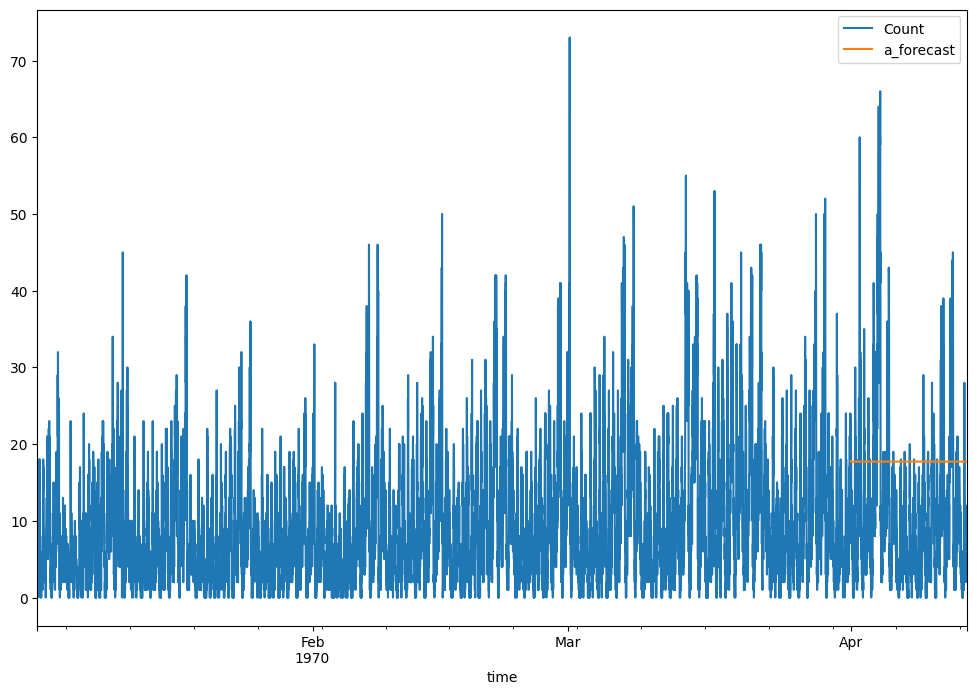

In [49]:
count['a_forecast']=arima_model.predict(start=8560,end=9788,dynamic=True)
count[['Count','a_forecast']].plot(figsize=(12,8))

In [51]:
arima_rmse = np.sqrt(mean_squared_error(test["Count"].values, count['a_forecast'].dropna()))
print("RMSE for Arima: ",arima_rmse)

RMSE for Arima:  12.018392413651945


# Sarimax

Here I have tried building a Sarimax model with a seasonality of 48 time periods

In [386]:
smodel=sm.tsa.statespace.SARIMAX(count['Count'],order=(1, 1, 1),seasonal_order=(1,1,1,48))

In [387]:
sarima_model=smodel.fit()

<AxesSubplot: xlabel='time'>

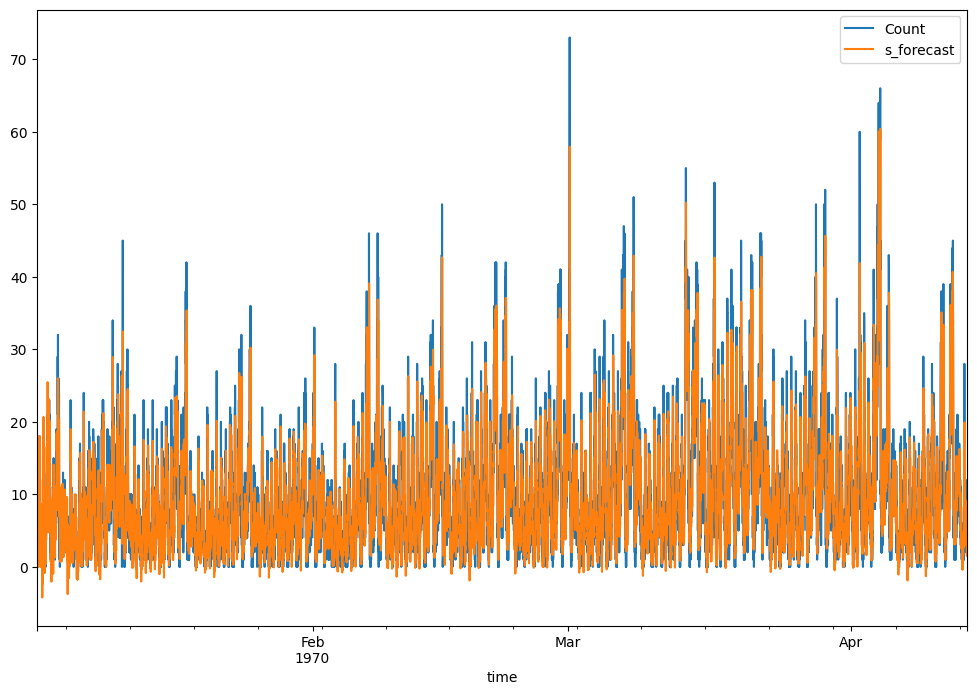

In [394]:
count['s_forecast']=sarima_model.predict(start=0,end=9788,dynamic=False)
count[['Count','s_forecast']].plot(figsize=(12,8))

In [395]:
sarima_rmse = np.sqrt(mean_squared_error(count["Count"].values, count['s_forecast']))
print("RMSE for Sarima: ",sarima_rmse)

RMSE for Sarima:  4.387577762708806


In [396]:
n = sarima_model.predict(start=9788,end=9792)

In [397]:
#Predictions from Sarimax
n

1970-04-13 19:00:00    5.454453
1970-04-13 19:15:00    5.292767
1970-04-13 19:30:00    5.684995
1970-04-13 19:45:00    5.738634
1970-04-13 20:00:00    5.620637
Freq: 15T, Name: predicted_mean, dtype: float64

# LSTM Predictions

Following the lack luster performance of Arima and Sarimax, next approach is to build a vanila LSTM Model with the time series data.

Building the dependencies : 

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#!pip install keras
#!pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# Data Transformations and functions

In [18]:
#Transforming the time-series to supervised learning model

def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

#scaling the range of the activation function -> tanh
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [34]:
# load data 
raw_values = c1['Count'].values
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(raw_values, 1)
supervised_values = supervised.values


In [97]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [335]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [144]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 70, 20)

# We have identified the hyperparameters by increasing in increments of 10 for epochs and 5 for neurons. 
# While we havennt seen a plateau of convergence, values higher than this are computationally expensive


# forecast the entire training dataset to build up state for forecasting

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

9776/9776 [==============================] - 10s 1ms/step


array([[-0.7571928 ],
       [-0.8575293 ],
       [-0.8277833 ],
       ...,
       [-0.7519208 ],
       [-0.83107835],
       [-0.87289894]], dtype=float32)

In [343]:
lstm_model

1/1 [==============================] - 0s 14ms/step
Month=1, Predicted=5.793613, Expected=7.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=6.883361, Expected=8.000000
1/1 [==============================] - 0s 18ms/step
Month=3, Predicted=7.808800, Expected=4.000000
1/1 [==============================] - 0s 16ms/step
Month=4, Predicted=6.238259, Expected=3.000000
1/1 [==============================] - 0s 16ms/step
Month=5, Predicted=5.182951, Expected=5.000000
1/1 [==============================] - 0s 18ms/step
Month=6, Predicted=5.699015, Expected=3.000000
1/1 [==============================] - 0s 15ms/step
Month=7, Predicted=4.978578, Expected=9.000000
1/1 [==============================] - 0s 13ms/step
Month=8, Predicted=7.381544, Expected=5.000000
1/1 [==============================] - 0s 15ms/step
Month=9, Predicted=6.463824, Expected=5.000000
1/1 [==============================] - 0s 16ms/step
Month=10, Predicted=6.061202, Expected=2.000000
1/1 [====

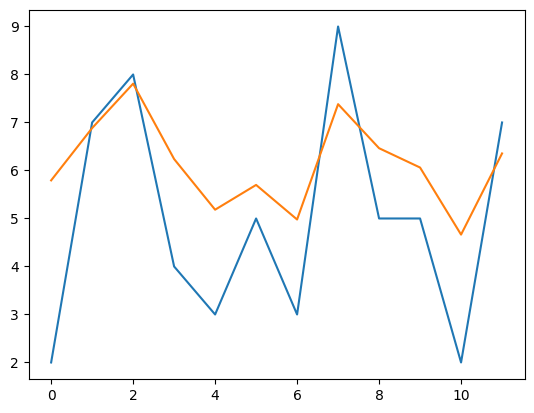

In [383]:
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
 # make one-step forecast
 X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
 yhat = forecast_lstm(lstm_model, 1, X)
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 # store forecast
 predictions.append(yhat)
 expected = raw_values[len(train) + i]
 print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-13:-1], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-13:-1])
pyplot.plot(predictions)
pyplot.show()

We can see that the model performs excellent with reasonably good predictions : 

So we will proceed to make the next 4 predictions using the same data.

In [384]:
# Making the next 4 predictions based on the last value

new_pred = [predictions.copy()[-1]]

for i in range(4):
    
    fin = new_pred[-1]
    p_new = scaler.transform([[fin,fin]])[0][0]
    X_new = np.array([p_new])
    pred_new = forecast_lstm(lstm_model, 1, X_new)
    pred_new = invert_scale(scaler, X_new, pred_new)
    new_pred.append(pred_new)

1/1 [==============================] - 0s 15ms/step


In [385]:
for i in range(4):
    print("The predictions for {} time sequence over is :".format(i+1),new_pred[i+1])

The predictions for 1 time sequence over is : 6.725359857082367
The predictions for 2 time sequence over is : 6.987594306468964
The predictions for 3 time sequence over is : 7.24479666352272
The predictions for 4 time sequence over is : 7.47957107424736
